<a href="https://colab.research.google.com/github/Yash1289/rossmann_sales_prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
path1 = "/content/drive/MyDrive/Rossmann Stores Data.csv"
rossmann_df = pd.read_csv(path1 , low_memory = False)

In [ ]:
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
rossmann_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [ ]:
rossmann_df.shape

(1017209, 9)

In [ ]:
path2 = "/content/drive/MyDrive/store.csv"
store_df = pd.read_csv(path2)

In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
store_df.shape

(1115, 10)

In [ ]:
rossmann_df["Store"].value_counts()


1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

In [ ]:
rossmann_df["DayOfWeek"].unique()

array([5, 4, 3, 2, 1, 7, 6])

In [ ]:
rossmann_df[rossmann_df.duplicated( subset = ["Store" , "Date"])]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [ ]:
pd.DataFrame(rossmann_df.dtypes).rename(columns = {0:'dtype'})

,dtype
Store,int64
DayOfWeek,int64
Date,object
Sales,int64
Customers,int64
Open,int64
Promo,int64
StateHoliday,object
SchoolHoliday,int64


In [ ]:
rossmann_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [ ]:
rossmann_df = pd.merge(rossmann_df , store_df , how = "left" , on="Store")
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
rossmann_df.shape

(1017209, 18)

In [ ]:
rossmann_df["Date"] = pd.to_datetime(rossmann_df["Date"])

In [ ]:
rossmann_df["Date"].max()

Timestamp('2015-07-31 00:00:00')

In [ ]:
rossmann_df["Date"].min()

Timestamp('2013-01-01 00:00:00')

In [ ]:
rossmann_sales_df = rossmann_df.copy()

In [ ]:
rossmann_sales_df = rossmann_sales_df.sort_values(by = "Date", ignore_index = True)

In [ ]:
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,NaN,NaN,0,NaN,NaN,NaN
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,NaN,NaN,NaN
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,NaN,NaN,NaN


In [ ]:
index_places = rossmann_sales_df[rossmann_sales_df["Open"] == 0].index
rossmann_sales_df.drop(index_places , inplace = True )


In [ ]:
rossmann_sales_df.reset_index(drop = True , inplace = True)

In [ ]:
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,353,2,2013-01-01,3139,820,1,0,a,1,b,b,900.0,NaN,NaN,1,14.0,2013.0,"Feb,May,Aug,Nov"
1,335,2,2013-01-01,2401,482,1,0,a,1,b,a,90.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
2,512,2,2013-01-01,2646,625,1,0,a,1,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec"
3,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,6.0,2011.0,0,NaN,NaN,NaN
4,530,2,2013-01-01,2907,532,1,0,a,1,a,c,18160.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
rossmann_sales_df.shape

(844392, 18)

In [ ]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
dtype: int64

In [ ]:

rossmann_sales_df["CompetitionOpenSinceMonth"] = np.where(rossmann_sales_df["CompetitionDistance"].isna() , 0 , rossmann_sales_df["CompetitionOpenSinceMonth"])
rossmann_sales_df["CompetitionOpenSinceYear"] = np.where(rossmann_sales_df["CompetitionDistance"].isna() , 0 , rossmann_sales_df["CompetitionOpenSinceYear"])
rossmann_sales_df["CompetitionDistance"] = rossmann_sales_df["CompetitionDistance"].fillna(0)


In [ ]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    266433
CompetitionOpenSinceYear     266433
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
dtype: int64

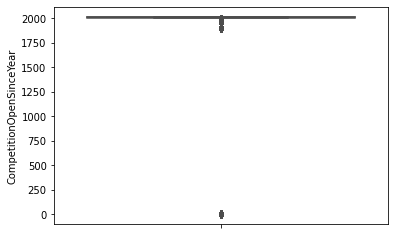

In [ ]:
import seaborn as sns

sns.boxplot( y = "CompetitionOpenSinceYear" , data = rossmann_sales_df, palette = "bright")

In [ ]:

rossmann_sales_df["CompetitionOpenSinceYear"] = np.where(rossmann_sales_df["CompetitionOpenSinceYear"].isna() , rossmann_sales_df["CompetitionOpenSinceYear"].mode() , rossmann_sales_df["CompetitionOpenSinceYear"])
rossmann_sales_df["CompetitionOpenSinceMonth"] = np.where(rossmann_sales_df["CompetitionOpenSinceMonth"].isna() , rossmann_sales_df["CompetitionOpenSinceMonth"].mode() , rossmann_sales_df["CompetitionOpenSinceMonth"])


In [ ]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
dtype: int64

In [ ]:
checking_df = rossmann_sales_df.copy()

In [ ]:
for index, row in rossmann_sales_df.iterrows():
  if row["Date"].year < row["CompetitionOpenSinceYear"] or(row["Date"].year == row["CompetitionOpenSinceYear"] and row["Date"].month < row["CompetitionOpenSinceMonth"]) :
    rossmann_sales_df.at[index, "CompetitionOpenSinceYear"] = 0 
    rossmann_sales_df.at[index, "CompetitionOpenSinceMonth"] = 0
    rossmann_sales_df.at[index, "CompetitionDistance"] = 0

In [ ]:
checking_df[(checking_df["Date"] == "2013-09-10") & (checking_df["Store"] == 838)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
234332,838,2,2013-09-10,9068,863,1,1,0,0,d,c,6890.0,9.0,2013.0,1,48.0,2011.0,"Mar,Jun,Sept,Dec"


In [ ]:
rossmann_new = checking_df.copy()

In [ ]:
def MonthsOfCompetition(row):
  if row["CompetitionOpenSinceYear"] != 0:
    return ((row["Date"].year - row["CompetitionOpenSinceYear"])*12 + (row["Date"].month - row["CompetitionOpenSinceMonth"]))
  else:
    return 0

In [ ]:
rossmann_sales_df["NumberOfMonthsFacedCompetition"] = rossmann_sales_df.apply(MonthsOfCompetition , axis = 1)

In [ ]:
rossmann_sales_df.drop(["CompetitionOpenSinceMonth" , "CompetitionOpenSinceYear"] , axis = 1 , inplace = True )

In [ ]:
final_df = rossmann_new.copy()

In [ ]:
rossmann_sales_df.isnull().sum()

Store                                  0
DayOfWeek                              0
Date                                   0
Sales                                  0
Customers                              0
Open                                   0
Promo                                  0
StateHoliday                           0
SchoolHoliday                          0
StoreType                              0
Assortment                             0
CompetitionDistance                    0
Promo2                                 0
Promo2SinceWeek                   423307
Promo2SinceYear                   423307
PromoInterval                     423307
NumberOfMonthsFacedCompetition         0
dtype: int64

In [ ]:
rossmann_sales_df["PromoInterval"] = rossmann_sales_df["PromoInterval"].fillna(0)

In [ ]:
def PromoMonth(row):
  if isinstance(row["PromoInterval"], str):
    if row["Date"].strftime("%b") in row["PromoInterval"].split(","):
      return 1
    else:
      return 0
  else:
    return -1


In [ ]:
rossmann_sales_df["isPromoMonth"] = rossmann_sales_df.apply(PromoMonth ,axis = 1)

In [ ]:
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,NumberOfMonthsFacedCompetition,isPromoMonth
0,353,2,2013-01-01,3139,820,1,0,a,1,b,b,0.0,1,14.0,2013.0,"Feb,May,Aug,Nov",0.0,0
1,335,2,2013-01-01,2401,482,1,0,a,1,b,a,0.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",0.0,1
2,512,2,2013-01-01,2646,625,1,0,a,1,b,b,0.0,1,5.0,2013.0,"Mar,Jun,Sept,Dec",0.0,0
3,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,0,NaN,NaN,0,19.0,-1
4,530,2,2013-01-01,2907,532,1,0,a,1,a,c,0.0,0,NaN,NaN,0,0.0,-1


In [ ]:
rossmann_sales_df.drop(["PromoInterval"] , axis=1 , inplace = True)

In [ ]:
def Promo2Running(row):
  if row["Promo2"] != 0 :
    if ( row["Date"].year < row["Promo2SinceYear"] ) or ( row["Date"].year == row["Promo2SinceYear"] and row["Date"].month < (row["Promo2SinceWeek"]//4 +1)):
      return 0
    else:
      return 1
  else:
    return 0

In [ ]:
rossmann_sales_df["Promo2"] = rossmann_sales_df.apply(Promo2Running , axis = 1)

In [ ]:
last_df = final_df.copy()

In [ ]:
rossmann_sales_df["isPromoMonth"].value_counts()

-1    423307
 0    280926
 1    140159
Name: isPromoMonth, dtype: int64

In [ ]:
rossmann_sales_df["isPromoMonth"] = np.where(rossmann_sales_df["Promo2"] == 0 , -1 , rossmann_sales_df["isPromoMonth"])

In [ ]:
rossmann_sales_df["isPromoMonth"].value_counts()

-1    481194
 0    241372
 1    121826
Name: isPromoMonth, dtype: int64

In [ ]:
rossmann_sales_df.isnull().sum()

Store                                  0
DayOfWeek                              0
Date                                   0
Sales                                  0
Customers                              0
Open                                   0
Promo                                  0
StateHoliday                           0
SchoolHoliday                          0
StoreType                              0
Assortment                             0
CompetitionDistance                    0
Promo2                                 0
Promo2SinceWeek                   423307
Promo2SinceYear                   423307
NumberOfMonthsFacedCompetition         0
isPromoMonth                           0
dtype: int64

In [ ]:
rossmann_sales_df["Promo2SinceWeek"] = rossmann_sales_df["Promo2SinceWeek"].fillna(0)
rossmann_sales_df["Promo2SinceYear"] = rossmann_sales_df["Promo2SinceYear"].fillna(0)

In [ ]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
NumberOfMonthsFacedCompetition    0
isPromoMonth                      0
dtype: int64

In [ ]:
def MonthsPromo2(row):
  if row["Promo2"] != 0:
    return (( row["Date"].year - row["Promo2SinceYear"])*12 + (row["Date"].month - (row["Promo2SinceWeek"]//4 +1)))
  else:
    return 0

In [ ]:
rossmann_sales_df["MonthsOfPromo2"] = rossmann_sales_df.apply(MonthsPromo2 , axis = 1)

In [ ]:
rossmann_sales_df.drop(["Promo2SinceYear" , "Promo2SinceWeek"] , axis = 1 , inplace = True )

In [ ]:
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2
0,353,2,2013-01-01,3139,820,1,0,a,1,b,b,0.0,0,0.0,-1,0.0
1,335,2,2013-01-01,2401,482,1,0,a,1,b,a,0.0,0,0.0,-1,0.0
2,512,2,2013-01-01,2646,625,1,0,a,1,b,b,0.0,0,0.0,-1,0.0
3,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,0,19.0,-1,0.0
4,530,2,2013-01-01,2907,532,1,0,a,1,a,c,0.0,0,0.0,-1,0.0


In [ ]:
rossmann_temp_df = rossmann_sales_df.copy()

In [ ]:
rossmann_temp_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2
0,353,2,2013-01-01,3139,820,1,0,a,1,b,b,0.0,0,0.0,-1,0.0
1,335,2,2013-01-01,2401,482,1,0,a,1,b,a,0.0,0,0.0,-1,0.0
2,512,2,2013-01-01,2646,625,1,0,a,1,b,b,0.0,0,0.0,-1,0.0
3,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,0,19.0,-1,0.0
4,530,2,2013-01-01,2907,532,1,0,a,1,a,c,0.0,0,0.0,-1,0.0


In [ ]:
rossmann_temp_df = pd.get_dummies( rossmann_temp_df , columns = ["StoreType" , "Assortment" ] , prefix = ["StoreType", "AssortmentLevel"])

In [ ]:
rossmann_temp_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,AssortmentLevel_a,AssortmentLevel_b,AssortmentLevel_c
0,353,2,2013-01-01,3139,820,1,0,a,1,0.0,0,0.0,-1,0.0,0,1,0,0,0,1,0
1,335,2,2013-01-01,2401,482,1,0,a,1,0.0,0,0.0,-1,0.0,0,1,0,0,1,0,0
2,512,2,2013-01-01,2646,625,1,0,a,1,0.0,0,0.0,-1,0.0,0,1,0,0,0,1,0
3,494,2,2013-01-01,3113,527,1,0,a,1,1260.0,0,19.0,-1,0.0,0,1,0,0,1,0,0
4,530,2,2013-01-01,2907,532,1,0,a,1,0.0,0,0.0,-1,0.0,1,0,0,0,0,0,1


In [ ]:
encoder_nums = { "StateHoliday" : { "0" : 0 , "a" : 1 , "b" : 3 , "c" : 2 } } 

rossmann_temp_df = rossmann_temp_df.replace(encoder_nums)

In [ ]:
rossmann_temp_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,AssortmentLevel_a,AssortmentLevel_b,AssortmentLevel_c
0,353,2,2013-01-01,3139,820,1,0,1,1,0.0,0,0.0,-1,0.0,0,1,0,0,0,1,0
1,335,2,2013-01-01,2401,482,1,0,1,1,0.0,0,0.0,-1,0.0,0,1,0,0,1,0,0
2,512,2,2013-01-01,2646,625,1,0,1,1,0.0,0,0.0,-1,0.0,0,1,0,0,0,1,0
3,494,2,2013-01-01,3113,527,1,0,1,1,1260.0,0,19.0,-1,0.0,0,1,0,0,1,0,0
4,530,2,2013-01-01,2907,532,1,0,1,1,0.0,0,0.0,-1,0.0,1,0,0,0,0,0,1


In [ ]:
numerical_features = [ "CompetitionDistance" , "NumberOfMonthsFacedCompetition" , "MonthsOfPromo2" , "DayOfWeek" ,"Customers" , "Sales" ]

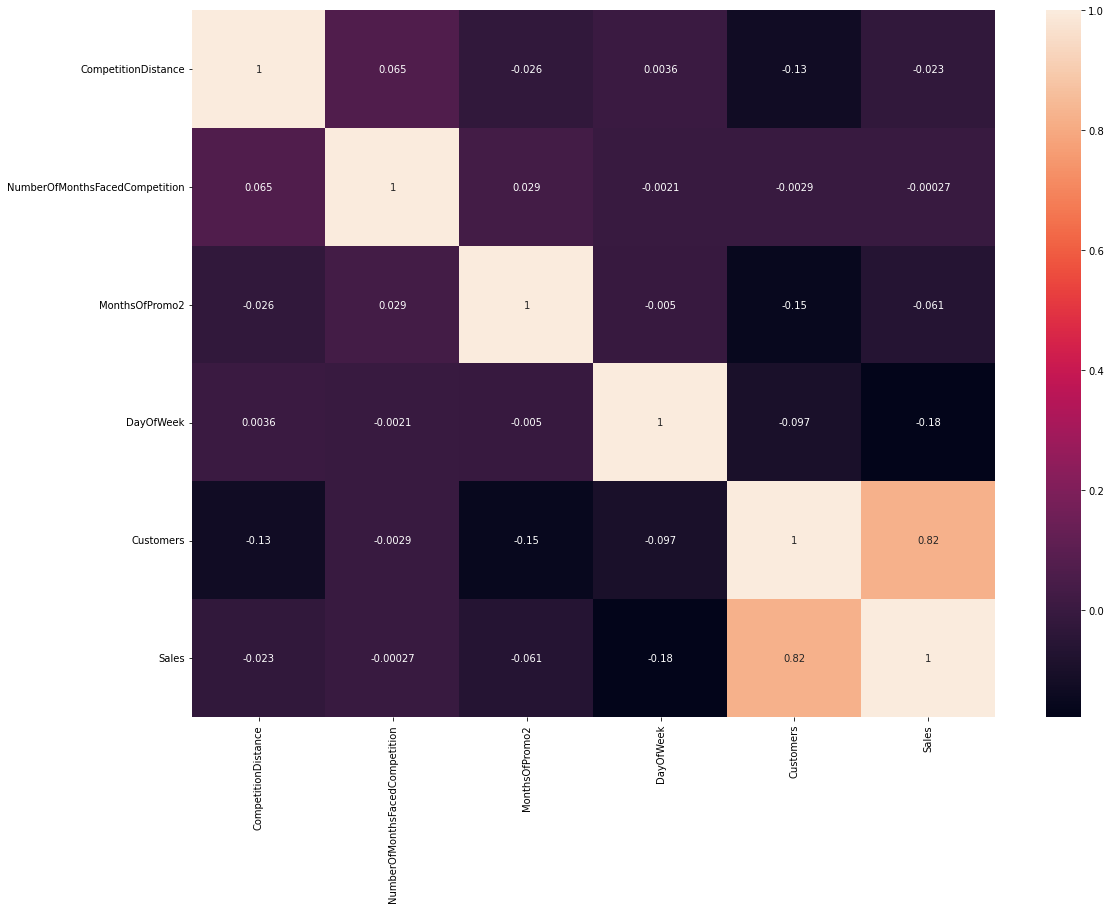

In [ ]:
plt.figure(figsize=(18, 13))
corr = rossmann_temp_df[numerical_features].corr()
sns.heatmap(corr , annot = True )

In [ ]:
rossmann_temp_df.describe().columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'Promo2',
       'NumberOfMonthsFacedCompetition', 'isPromoMonth', 'MonthsOfPromo2',
       'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'AssortmentLevel_a', 'AssortmentLevel_b', 'AssortmentLevel_c'],
      dtype='object')

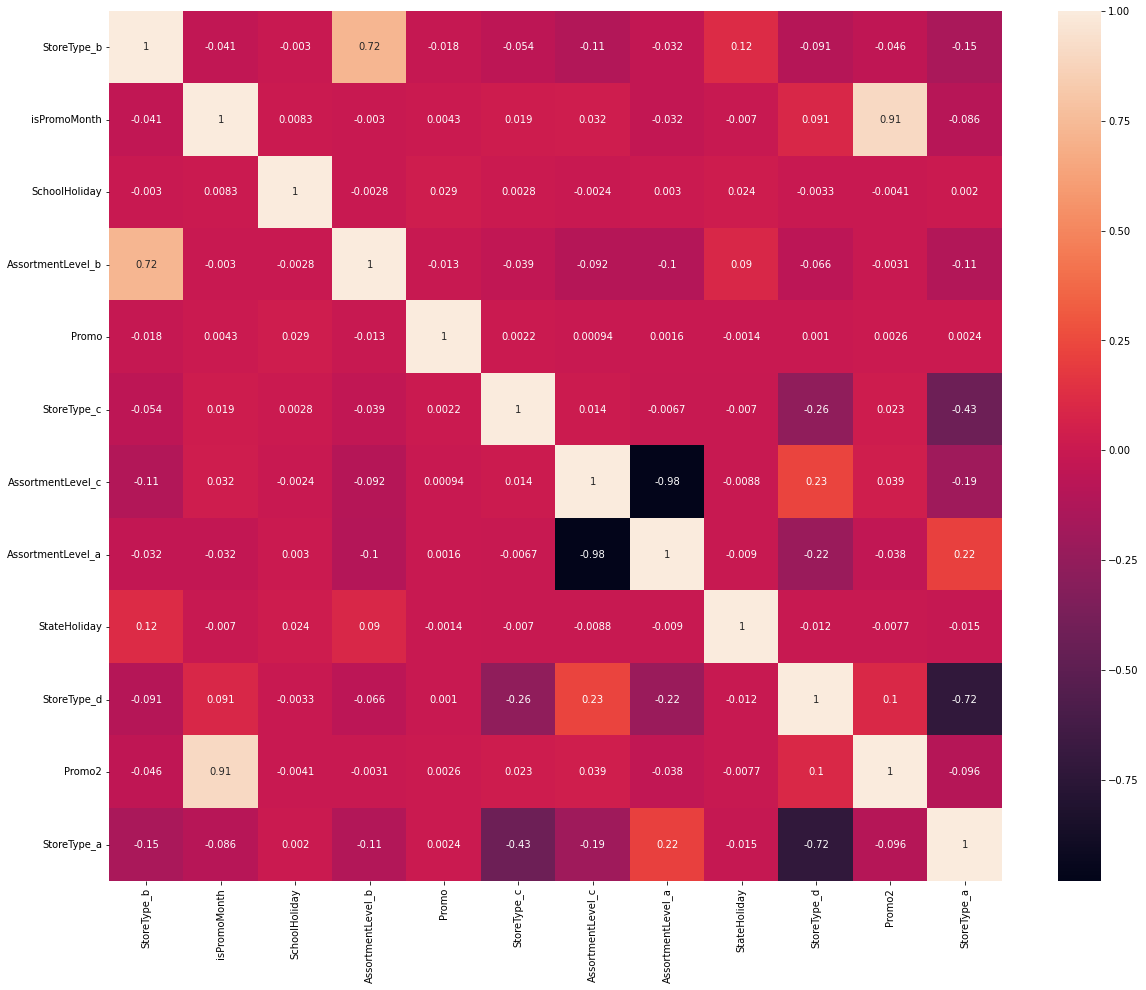

In [ ]:
plt.figure(figsize = (20,16))
otherFeatures = list(set(rossmann_temp_df.describe().columns) - set(numerical_features) - {"Store" , "Open"})
corr2 = rossmann_temp_df[otherFeatures].corr()
sns.heatmap(corr2 , annot = True)

In [ ]:
model_df = rossmann_temp_df.copy()

In [ ]:
model_df.drop(["Open"] , axis = 1 , inplace = True)

In [ ]:
zeroSale_index = model_df[model_df["Sales"] == 0].index
model_df.drop(zeroSale_index, inplace = True)

In [ ]:
model_df["Month"] = model_df["Date"].apply(lambda x : x.month)

In [ ]:
model_df["Year"] = model_df["Date"].apply(lambda x : x.year)

In [ ]:
model_df_groupby = model_df.groupby(["Store" , "Month" , "Year"]).agg({ "Sales" : "mean" , "Customers" : "mean" }).reset_index()

In [ ]:
grouped_df = model_df_groupby.sort_values(by = [ "Store" , "Year" , "Month" ] ,ignore_index="True")
grouped_df.tail()

,Store,Month,Year,Sales,Customers
33460,1115,3,2015,7193.884615,475.961538
33461,1115,4,2015,7233.333333,485.833333
33462,1115,5,2015,7574.347826,510.260870
33463,1115,6,2015,7301.720000,473.760000
33464,1115,7,2015,7021.740741,465.037037


In [ ]:
grouped_df.shape

(33465, 5)

In [ ]:
listOfStores = grouped_df["Store"].unique()

In [ ]:
shifted_df = grouped_df.copy()

for storeNo in listOfStores :
  shifted_df.loc[shifted_df["Store"] == storeNo , "Sales" ] = shifted_df[shifted_df["Store"] == storeNo ]["Sales"].shift( periods=2, fill_value=0 )
  shifted_df.loc[shifted_df["Store"] == storeNo , "Customers" ] = shifted_df[shifted_df["Store"] == storeNo ]["Customers"].shift( periods = 2 , fill_value = 0)


In [ ]:
shifted_df.head()

,Store,Month,Year,Sales,Customers
0,1,1,2013,0.000000,0.000
1,1,2,2013,0.000000,0.000
2,1,3,2013,4939.653846,611.500
3,1,4,2013,5219.625000,632.875
4,1,5,2013,5806.760000,702.960


In [ ]:
shifted_df.rename(columns = {"Sales" : "2MonthAgoSale" , "Customers" : "2MonthAgoCustomers" } ,inplace = True)

In [ ]:
test_final_df = pd.merge(model_df , shifted_df , how = "left" , on = ["Store" , "Month" , "Year"])

In [ ]:
backup_df = test_final_df.copy()

In [ ]:
index_places1 = backup_df[backup_df["2MonthAgoSale"] == 0].index
backup_df.drop( index_places1 , inplace = True )

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
correlation_features = ["CompetitionDistance" , "NumberOfMonthsFacedCompetition" , "MonthsOfPromo2" , "DayOfWeek" , "2MonthAgoSale" ]

In [ ]:
calc_vif(backup_df[correlation_features])

,variables,VIF
0,CompetitionDistance,1.344761
1,NumberOfMonthsFacedCompetition,1.464438
2,MonthsOfPromo2,1.403621
3,DayOfWeek,3.699320
4,2MonthAgoSale,3.880515


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
independent_features = backup_df.describe().columns
independent_features = list(set(independent_features) - {"Store" , "Sales" , "StoreType_a" ,"AssortmentLevel_a" , "Month" , "Year" , "2MonthAgoCustomers" ,"Customers"  })

In [ ]:
backup_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,AssortmentLevel_a,AssortmentLevel_b,AssortmentLevel_c,Month,Year,2MonthAgoSale,2MonthAgoCustomers
55547,373,5,2013-03-01,4074,308,0,0,0,0.0,1,0.0,0,9.0,0,0,0,1,0,0,1,3,2013,3795.307692,277.923077
55548,369,5,2013-03-01,6643,542,0,0,0,0.0,0,0.0,-1,0.0,0,0,0,1,0,0,1,3,2013,6424.153846,528.769231
55549,370,5,2013-03-01,7152,645,0,0,0,8250.0,1,149.0,0,43.0,0,0,0,1,1,0,0,3,2013,6823.461538,571.192308
55550,371,5,2013-03-01,5774,473,0,0,0,1970.0,0,44.0,-1,0.0,0,0,0,1,0,0,1,3,2013,6373.846154,514.269231
55551,372,5,2013-03-01,8214,759,0,0,0,4880.0,0,31.0,-1,0.0,0,0,0,1,0,0,1,3,2013,7761.884615,702.000000


In [ ]:
break_point = round(len(model_df)*0.90)
train_data = backup_df.iloc[:break_point]
test_data = backup_df.iloc[break_point:]
X_train = train_data[independent_features].copy()
Y_train = train_data["Sales"].copy()
X_test = test_data[independent_features].copy()
Y_test = test_data["Sales"].copy()

In [ ]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression()

In [ ]:
regressor.score( X_train  , Y_train)

0.7011965344927205

In [ ]:
Y_pred = regressor.predict(X_test)

In [ ]:
MSE  = mean_squared_error((Y_test), (Y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1613132.3499490807
RMSE : 1270.0914730636848
R2 : 0.8122062382695788
Adjusted R2 :  0.8121081668137435


In [ ]:
from sklearn.linear_model import Ridge
ridge  = Ridge(alpha= 100 , max_iter= 3000)

ridge.fit(X_train, Y_train)

Ridge(alpha=100, max_iter=3000)

In [ ]:
ridge.score(X_train , Y_train)

0.701107781405989

In [ ]:
Y_pred_ridge = ridge.predict(X_test)

In [ ]:
MSE  = mean_squared_error((Y_test), (Y_pred_ridge))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_ridge))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_ridge)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1612818.7395123134
RMSE : 1269.968007279047
R2 : 0.8122427474150562
Adjusted R2 :  0.8121446950253763


In [ ]:
best_model

RandomForestRegressor(max_depth=10, n_estimators=50)

In [191]:
break_point = round(len(model_df)*0.90)
train_data = backup_df.iloc[:break_point]
test_data = backup_df.iloc[break_point:]
X_train = train_data[independent_features].copy()
Y_train = train_data["Sales"].copy()
X_test = test_data[independent_features].copy()
Y_test = test_data["Sales"].copy()

In [173]:
round(len(model_df)*0.07)

59104

In [ ]:
from sklearn.tree import DecisionTreeRegressor

decision_reg = DecisionTreeRegressor(criterion = "squared_error" , max_depth = 12 , max_features = "auto" )
decision_reg.fit(X_train , Y_train)

DecisionTreeRegressor(max_depth=12, max_features='auto')

In [ ]:
decision_reg.score(X_train  , Y_train)

0.7938749623710931

In [ ]:
Y_pred_dec = decision_reg.predict(X_test)

In [ ]:
MSE  = mean_squared_error((Y_test), (Y_pred_dec))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_dec))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_dec)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1435265.7034599194
RMSE : 1198.0257524193373
R2 : 0.83291268968482
Adjusted R2 :  0.8328254317502475


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_reg = GradientBoostingRegressor()
gradient_reg.fit(X_train , Y_train)

GradientBoostingRegressor()

In [ ]:
Y_pred_grad =gradient_reg.predict(X_test)

In [ ]:
gradient_reg.score(X_train , Y_train)

0.7645722665851297

In [ ]:
MSE  = mean_squared_error((Y_test), (Y_pred_grad))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_grad))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_grad)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1338704.7081996452
RMSE : 1157.024074165981
R2 : 0.8441538953657629
Adjusted R2 :  0.8440725079212232


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

tscv = TimeSeriesSplit(n_splits = 3)
model = RandomForestRegressor()

param_search = {
    'n_estimators' : [35 ],
    'max_features' : ['auto'],
    'max_depth' : [i for i in range(12,20) ]
}

gsearch = GridSearchCV(estimator = model, param_grid = param_search , scoring = 'neg_mean_squared_error' )
gsearch.fit(X_train , Y_train)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [192]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

model = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

grid_values = {
    "learning_rate" : [ 0.1 ],
    "n_estimators" : [ 110 ],
    "max_depth" : [3]
}

gSearch = GridSearchCV( estimator = model , param_grid = grid_values , scoring = 'r2' , cv = tscv)
gSearch.fit(X_train , Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [110]},
             scoring='r2')

In [193]:
gSearch.best_score_

0.8021824502204853

In [194]:
Y_pred_grad = gSearch.predict(X_test)

In [195]:
MSE  = mean_squared_error((Y_test), (Y_pred_grad))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_grad))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_grad)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1338326.1249673232
RMSE : 1156.8604604563695
R2 : 0.8441979683578693
Adjusted R2 :  0.8441166039295495


In [ ]:
from sklearn.metrics import SCORERS

SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [185]:
from sklearn.linear_model import Ridge
ridge = Ridge()
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

parameters = {'alpha': [1e-6 , 1e-7 , 1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,50,60,100,0.0014]}
lasso_regressor = GridSearchCV(ridge , param_grid = parameters, scoring= 'r2' , cv=tscv)
lasso_regressor.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=Ridge(),
             param_grid={'alpha': [1e-06, 1e-07, 1e-05, 0.0001, 0.001, 0.01,
                                   0.1, 1, 5, 10, 20, 30, 40, 50, 60, 100,
                                   0.0014]},
             scoring='r2')

In [186]:
lasso_regressor.best_score_

0.7489143947155124

In [187]:
lasso_regressor.best_params_

{'alpha': 1e-07}

In [188]:
Y_pred_ridge = lasso_regressor.predict(X_test)

In [189]:
MSE  = mean_squared_error((Y_test), (Y_pred_ridge))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_ridge))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_ridge)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1613132.3499479073
RMSE : 1270.0914730632228
R2 : 0.8122062382697155
Adjusted R2 :  0.8121081668138803
